In [9]:
import sys
!{sys.executable} -m pip install -q pandas_datareader

In [10]:
import datetime

# Define end_date as today's date
end_date = datetime.date.today()

# Calculate start_date as five years prior to end_date
start_date = end_date - datetime.timedelta(days=5*365) # Approximate 5 years

In [11]:
import yfinance as yf

# Define the ticker symbol for USD/EUR
# Note: yfinance typically uses 'EURUSD=X' for EUR to USD, so for USD/EUR, we might need to invert later or adjust the interpretation
ticker_symbol = 'EURUSD=X'

# Download historical data
fx_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Display the first few rows of the DataFrame
print("Historical FX Spot Rates (USD/EUR):")
fx_data.head()

/tmp/ipython-input-2517740616.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  fx_data = yf.download(ticker_symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Historical FX Spot Rates (USD/EUR):


Price,Close,High,Low,Open,Volume
Ticker,EURUSD=X,EURUSD=X,EURUSD=X,EURUSD=X,EURUSD=X
Date,,,,,
2021-02-12,1.213151,1.213592,1.208399,1.213003,0
2021-02-15,1.212209,1.214699,1.211739,1.212106,0
2021-02-16,1.213220,1.217100,1.209585,1.213239,0
2021-02-17,1.209248,1.209834,1.202559,1.208854,0
2021-02-18,1.204800,1.208900,1.203630,1.204587,0


In [12]:
import pandas as pd

# Extract the 'Close' price for EURUSD=X
euro_usd_close = fx_data['Close']['EURUSD=X']

# Invert to get USD/EUR spot rate (1 / EURUSD)
usd_eur_spot_rates = 1 / euro_usd_close

# Display the first few inverted spot rates
print("USD/EUR Historical Spot Rates (inverted from EUR/USD):")
print(usd_eur_spot_rates.head())

USD/EUR Historical Spot Rates (inverted from EUR/USD):
Date
2021-02-12    0.824300
2021-02-15    0.824940
2021-02-16    0.824253
2021-02-17    0.826960
2021-02-18    0.830013
Name: EURUSD=X, dtype: float64


In [13]:
import numpy as np

# Calculate daily logarithmic returns
log_returns = np.log(usd_eur_spot_rates / usd_eur_spot_rates.shift(1))

# Calculate the daily standard deviation of returns
daily_volatility = log_returns.std()

# Annualize the volatility (assuming 252 trading days in a year)
annualized_volatility = daily_volatility * np.sqrt(252)

print(f"Calculated Historical Daily Volatility: {daily_volatility:.4f}")
print(f"Calculated Historical Annualized Volatility: {annualized_volatility:.4f}")

Calculated Historical Daily Volatility: 0.0047
Calculated Historical Annualized Volatility: 0.0752


In [16]:
import pandas_datareader.data as web

# Fetch historical 1-year US Treasury Constant Maturity Rate (DGS1) for USD
usd_ir_data = web.DataReader('DGS1', 'fred', start=start_date, end=end_date)

# Fetch historical Euro Area 1-Year Interest Rate (IRSTCI01EZM156N) for EUR
eur_ir_data = web.DataReader('IRSTCI01EZM156N', 'fred', start=start_date, end=end_date)

print("USD Historical Interest Rates (last 5 rows):")
print(usd_ir_data.tail())
print("\nEUR Historical Interest Rates (last 5 rows):")
print(eur_ir_data.tail())

USD Historical Interest Rates (last 5 rows):
            DGS1
DATE            
2026-02-03  3.49
2026-02-04  3.49
2026-02-05  3.44
2026-02-06  3.45
2026-02-09  3.43

EUR Historical Interest Rates (last 5 rows):
            IRSTCI01EZM156N
DATE                       
2025-08-01         1.924340
2025-09-01         1.924563
2025-10-01         1.926376
2025-11-01         1.928931
2025-12-01         1.929357


In [17]:
import pandas as pd

# Rename columns for easier access
usd_ir_data = usd_ir_data.rename(columns={'DGS1': 'USD_IR'}) / 100 # Convert to decimal
eur_ir_data = eur_ir_data.rename(columns={'IRSTCI01EZM156N': 'EUR_IR'}) / 100 # Convert to decimal

# Combine interest rate dataframes and resample to daily frequency, then interpolate
# We'll align it with the index of usd_eur_spot_rates which is daily.
all_dates = pd.date_range(start=usd_eur_spot_rates.index.min(), end=usd_eur_spot_rates.index.max(), freq='D')

# Reindex interest rates to the full date range and interpolate missing values
usd_ir_data_daily = usd_ir_data.reindex(all_dates).ffill().bfill()
eur_ir_data_daily = eur_ir_data.reindex(all_dates).ffill().bfill()

# Merge with spot rates, ensuring common dates
combined_data = pd.DataFrame({
    'USD_EUR_Spot': usd_eur_spot_rates,
    'USD_IR': usd_ir_data_daily['USD_IR'],
    'EUR_IR': eur_ir_data_daily['EUR_IR']
}).dropna()

print("Combined Data (Spot Rates and Interest Rates):")
print(combined_data.head())
print(combined_data.tail())
print("\nShape of combined_data:", combined_data.shape)

Combined Data (Spot Rates and Interest Rates):
            USD_EUR_Spot  USD_IR    EUR_IR
2021-02-12      0.824300  0.0006 -0.005638
2021-02-15      0.824940  0.0006 -0.005638
2021-02-16      0.824253  0.0008 -0.005638
2021-02-17      0.826960  0.0007 -0.005638
2021-02-18      0.830013  0.0006 -0.005638
            USD_EUR_Spot  USD_IR    EUR_IR
2026-02-04       0.84630  0.0349  0.019294
2026-02-05       0.84734  0.0344  0.019294
2026-02-06       0.84905  0.0345  0.019294
2026-02-09       0.84561  0.0343  0.019294
2026-02-10       0.84005  0.0343  0.019294

Shape of combined_data: (1298, 3)


In [18]:
import numpy as np

# Extract the latest spot rate and interest rates from combined_data
latest_data = combined_data.iloc[-1]
current_spot_rate = latest_data['USD_EUR_Spot']
risk_free_rate_usd = latest_data['USD_IR']
risk_free_rate_eur = latest_data['EUR_IR']

# Define simulation parameters
T = tenor_years # Time to maturity in years
num_simulations = num_paths # Number of Monte Carlo paths
dt = 1/252 # Time step (assuming 252 trading days in a year)

# Annualized volatility from previous calculation
volatility = annualized_volatility

print(f"Current Spot Rate (USD/EUR): {current_spot_rate:.4f}")
print(f"Current USD Risk-Free Rate: {risk_free_rate_usd:.4f}")
print(f"Current EUR Risk-Free Rate: {risk_free_rate_eur:.4f}")
print(f"Annualized Volatility: {volatility:.4f}")
print(f"Time to Maturity (Years): {T}")
print(f"Number of Simulations: {num_simulations}")


Current Spot Rate (USD/EUR): 0.8400
Current USD Risk-Free Rate: 0.0343
Current EUR Risk-Free Rate: 0.0193
Annualized Volatility: 0.0752
Time to Maturity (Years): 5
Number of Simulations: 10000


In [19]:
import numpy as np

# Define the tenor for the FX forward (Time to maturity in years)
T = tenor_years

# Define the notional amount for the FX forward contract (e.g., 1,000,000 USD)
notional_amount = 1_000_000

print(f"Time to Maturity (T) for FX Forward: {T} years")
print(f"Notional Amount: {notional_amount}")

Time to Maturity (T) for FX Forward: 5 years
Notional Amount: 1000000


In [20]:
import numpy as np

# Calculate the number of time steps
num_steps = int(T / dt)

print(f"Number of Time Steps for Simulation: {num_steps}")

Number of Time Steps for Simulation: 1260


In [21]:
import numpy as np

# Initialize array to store simulated paths
simulated_spot_paths = np.zeros((num_simulations, num_steps + 1))

# Set the initial spot rate for all paths
simulated_spot_paths[:, 0] = current_spot_rate

print(f"Initialized an array for simulated spot paths with shape: {simulated_spot_paths.shape}")

Initialized an array for simulated spot paths with shape: (10000, 1261)


In [22]:
import numpy as np

# Simulate FX spot rate paths using Geometric Brownian Motion
for i in range(1, num_steps + 1):
    # Generate random numbers for the Wiener process
    Z = np.random.standard_normal(num_simulations)

    # Calculate the drift and diffusion terms for the FX rate under the risk-neutral measure
    # S_t = S_{t-1} * exp((r_d - r_f - 0.5 * sigma^2) * dt + sigma * sqrt(dt) * Z)
    # Where r_d is domestic rate (USD), r_f is foreign rate (EUR)
    # The spot rate is USD/EUR, so USD is the domestic currency.
    drift = (risk_free_rate_usd - risk_free_rate_eur - 0.5 * volatility**2) * dt
    diffusion = volatility * np.sqrt(dt) * Z

    # Update the spot rate for the current time step
    simulated_spot_paths[:, i] = simulated_spot_paths[:, i-1] * np.exp(drift + diffusion)

print("Completed Monte Carlo simulation for FX spot rates.")
print("First 5 rows and columns of simulated_spot_paths:")
print(simulated_spot_paths[:5, :5])

Completed Monte Carlo simulation for FX spot rates.
First 5 rows and columns of simulated_spot_paths:
[[0.84004997 0.84347693 0.8472328  0.84768829 0.85380884]
 [0.84004997 0.83668598 0.83799556 0.83686071 0.83220042]
 [0.84004997 0.84396141 0.84796776 0.84477686 0.83796751]
 [0.84004997 0.83803592 0.83483922 0.83565317 0.82435896]
 [0.84004997 0.84587248 0.84911985 0.85425223 0.85430546]]


In [23]:
import numpy as np

# Extract the final simulated spot rates (at maturity T)
final_simulated_spot_rates = simulated_spot_paths[:, -1]

# Calculate the Monte Carlo estimated forward FX rate as the average of the final rates
mc_forward_rate = np.mean(final_simulated_spot_rates)

print(f"Monte Carlo Estimated Forward FX Rate (USD/EUR) at maturity {T} years: {mc_forward_rate:.4f}")

Monte Carlo Estimated Forward FX Rate (USD/EUR) at maturity 5 years: 0.9055


In [24]:
import numpy as np

# Calculate the forward FX rate using Interest Rate Parity (IRP)
# F = S * (1 + r_d * T) / (1 + r_f * T) for discrete compounding
# or F = S * exp((r_d - r_f) * T) for continuous compounding (which is more appropriate for rates from FRED usually)

# Using continuous compounding which is often assumed for risk-free rates in such models
irp_forward_rate = current_spot_rate * np.exp((risk_free_rate_usd - risk_free_rate_eur) * T)

print(f"Forward FX Rate (USD/EUR) via IRP at maturity {T} years: {irp_forward_rate:.4f}")

Forward FX Rate (USD/EUR) via IRP at maturity 5 years: 0.9055


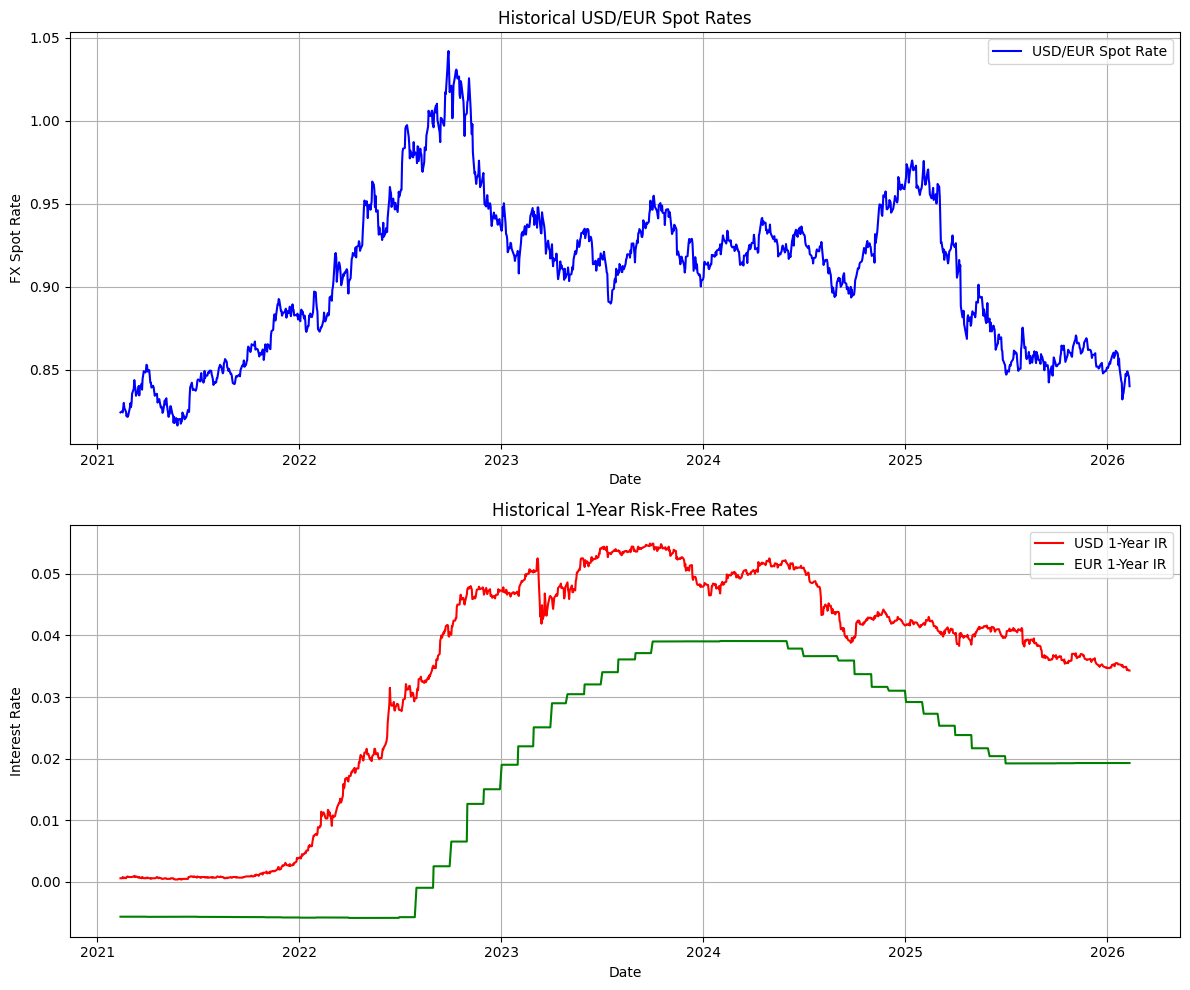

Visualized historical FX rates and risk-free rates.


In [25]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

# Plot Historical USD/EUR Spot Rates
axes[0].plot(combined_data.index, combined_data['USD_EUR_Spot'], label='USD/EUR Spot Rate', color='blue')
axes[0].set_title('Historical USD/EUR Spot Rates')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('FX Spot Rate')
axes[0].legend()
axes[0].grid(True)

# Plot Historical Interest Rates
axes[1].plot(combined_data.index, combined_data['USD_IR'], label='USD 1-Year IR', color='red')
axes[1].plot(combined_data.index, combined_data['EUR_IR'], label='EUR 1-Year IR', color='green')
axes[1].set_title('Historical 1-Year Risk-Free Rates')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Interest Rate')
axes[1].legend()
axes[1].grid(True)

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()
plt.show()

print("Visualized historical FX rates and risk-free rates.")

In [27]:
import QuantLib as ql
import datetime

# 1. Set up the evaluation date (today's date)
# QuantLib dates are typically (day, month, year)
todays_date = datetime.date.today()
evaluation_date = ql.Date(todays_date.day, todays_date.month, todays_date.year)
ql.Settings.instance().evaluationDate = evaluation_date

# 2. Define the QuantLib parameters using the kernel variables
spot_fx_rate = current_spot_rate
volatility_ql = annualized_volatility
risk_free_rate_usd_ql = risk_free_rate_usd
risk_free_rate_eur_ql = risk_free_rate_eur
strike_ql = strike # Assuming 'strike' is already defined in the kernel as 1.2

print(f"QuantLib Evaluation Date: {evaluation_date}")
print(f"Spot FX Rate (USD/EUR): {spot_fx_rate:.4f}")
print(f"Annualized Volatility: {volatility_ql:.4f}")
print(f"USD Risk-Free Rate: {risk_free_rate_usd_ql:.4f}")
print(f"EUR Risk-Free Rate: {risk_free_rate_eur_ql:.4f}")
print(f"Strike Price: {strike_ql:.4f}")

QuantLib Evaluation Date: February 11th, 2026
Spot FX Rate (USD/EUR): 0.8400
Annualized Volatility: 0.0752
USD Risk-Free Rate: 0.0343
EUR Risk-Free Rate: 0.0193
Strike Price: 1.2000


In [29]:
import QuantLib as ql

# 1. Initialize a ql.Actual365Fixed() day counter
day_count = ql.Actual365Fixed()

# 2. Create a ql.RelinkableYieldTermStructureHandle() for the USD yield curve
#    and link it to a ql.FlatForwardTermStructure
#    The domestic rate for USD/EUR is USD.
usd_yield_curve = ql.RelinkableYieldTermStructureHandle()
usd_yield_curve.linkTo(ql.FlatForward(evaluation_date, risk_free_rate_usd_ql, day_count, ql.Continuous, ql.Annual))

# 3. Create a ql.RelinkableYieldTermStructureHandle() for the EUR yield curve
#    and link it to a ql.FlatForwardTermStructure
#    The foreign rate for USD/EUR is EUR.
eur_yield_curve = ql.RelinkableYieldTermStructureHandle()
eur_yield_curve.linkTo(ql.FlatForward(evaluation_date, risk_free_rate_eur_ql, day_count, ql.Continuous, ql.Annual))

# 4. Create a ql.QuoteHandle for the spot_fx_rate
spot_fx_quote = ql.QuoteHandle(ql.SimpleQuote(spot_fx_rate))

# 5. Create a ql.BlackVolTermStructureHandle() and link it to a ql.BlackConstantVol
volatility_surface = ql.RelinkableBlackVolTermStructureHandle()
volatility_surface.linkTo(ql.BlackConstantVol(evaluation_date, ql.NullCalendar(), volatility_ql, day_count))

# 6. Initialize a ql.GeneralizedBlackScholesProcess
#    For an FX rate S_dom/for, the domestic rate is r_dom and foreign is r_for.
#    Here, USD/EUR, so USD is domestic and EUR is foreign.
fx_process = ql.GeneralizedBlackScholesProcess(
    spot_fx_quote,
    eur_yield_curve, # foreign risk-free rate
    usd_yield_curve, # domestic risk-free rate
    volatility_surface
)

# Print the forward rate from the reconstructed process as a check
# The forward rate is calculated using F = S * exp((r_dom - r_for) * T)
# Using the process, we can get this for a specific time T.
# Let's check for time T defined earlier (5 years)
# T needs to be converted to year fractions for QuantLib

# Use ql.Period(int(T), ql.Years) for exact years
maturity_date = evaluation_date + ql.Period(int(T), ql.Years)
year_fraction = day_count.yearFraction(evaluation_date, maturity_date)

# A better way to get the forward rate from the process is using the discount factors
domestic_discount = usd_yield_curve.discount(year_fraction)
foreign_discount = eur_yield_curve.discount(year_fraction)
forward_rate_ql_calc = spot_fx_rate * (domestic_discount / foreign_discount)

print(f"QuantLib Reconstructed Forward FX Rate (USD/EUR) for {T} years: {forward_rate_ql_calc:.4f}")

QuantLib Reconstructed Forward FX Rate (USD/EUR) for 5 years: 0.7793


In [32]:
import QuantLib as ql

# 1. Define the maturity date (exercise_date) for the option
mature_period = ql.Period(int(T), ql.Years)
exercise_date = evaluation_date + mature_period

# 2. Specify the option type as a Call option
option_type = ql.Option.Call

# 3. Create a plain vanilla payoff object
payoff = ql.PlainVanillaPayoff(option_type, strike_ql)

# 4. Construct a ql.EuropeanExercise object
exercise = ql.EuropeanExercise(exercise_date)

# 5. Create a ql.VanillaOption object
option = ql.VanillaOption(payoff, exercise)

# 6. Set up the Monte Carlo simulation engine
# Using 252 time steps per year (daily steps) for the simulation
time_steps_per_year = 252
# num_simulations comes from num_paths, which was set to 10000
mc_engine = ql.MCEuropeanEngine(
    fx_process,
    "PseudoRandom", # Using default PseudoRandom sequence generator
    timeStepsPerYear=time_steps_per_year, # Explicitly pass time steps per year
    requiredSamples=num_simulations,      # Explicitly pass number of simulations
    seed=42                               # for reproducibility
)

# 7. Link the Monte Carlo engine to the ql.VanillaOption
option.setPricingEngine(mc_engine)

# 8. Calculate the Net Present Value (NPV) of the option
npv_option = option.NPV()

# 9. Print the calculated NPV
print(f"Monte Carlo Estimated FX Option NPV: {npv_option:.4f}")

Monte Carlo Estimated FX Option NPV: 0.0027


In [33]:
import numpy as np

# Calculate the effective notional amount in EUR
# The strike_ql is USD/EUR, so dividing USD notional by this gives EUR notional
effective_notional_eur = notional_amount / strike_ql

# Calculate the total present value of the FX swaption
total_pv_fx_swaption = npv_option * effective_notional_eur

print(f"Assumed Notional Amount: {notional_amount:,.0f} USD")
print(f"Effective Notional Amount (EUR): {effective_notional_eur:,.2f} EUR")
print(f"Total Monte Carlo Estimated FX Swaption Present Value: {total_pv_fx_swaption:,.4f} USD")

Assumed Notional Amount: 1,000,000 USD
Effective Notional Amount (EUR): 833,333.33 EUR
Total Monte Carlo Estimated FX Swaption Present Value: 2,245.4166 USD


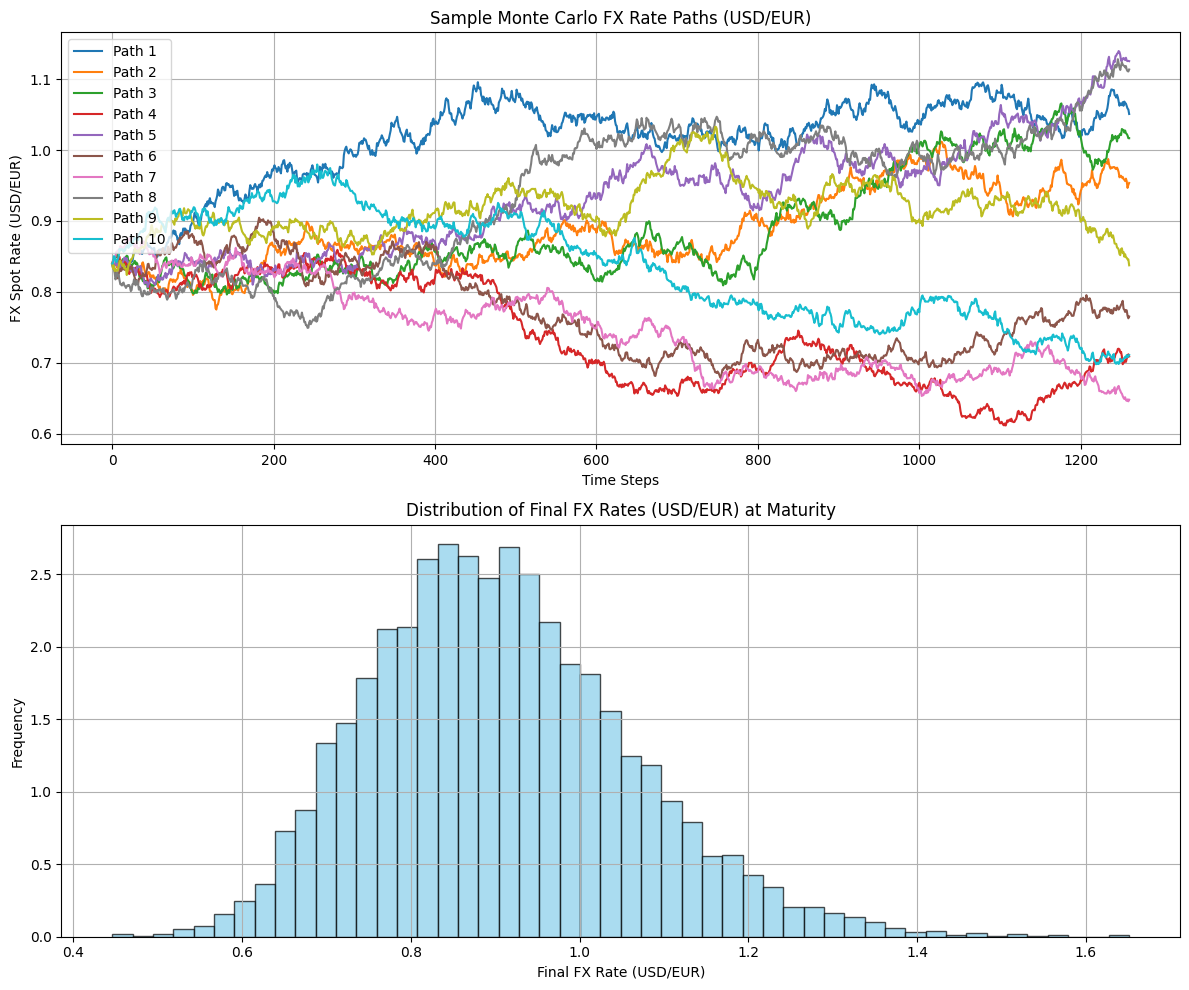

Generated plots for sample FX rate paths and a histogram of final FX rates.


In [34]:
import matplotlib.pyplot as plt

# Create a figure and a set of two subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

# --- First Subplot: Sample Monte Carlo FX Rate Paths ---
# Define a time array for the x-axis (representing time steps)
time_steps = np.arange(0, num_steps + 1)

# Plot a few randomly selected sample paths (e.g., 10 paths)
num_paths_to_plot = 10
random_indices = np.random.choice(num_simulations, num_paths_to_plot, replace=False)

for i, idx in enumerate(random_indices):
    axes[0].plot(time_steps, simulated_spot_paths[idx, :], label=f'Path {i+1}')

axes[0].set_title('Sample Monte Carlo FX Rate Paths (USD/EUR)')
axes[0].set_xlabel('Time Steps')
axes[0].set_ylabel('FX Spot Rate (USD/EUR)')
axes[0].legend()
axes[0].grid(True)

# --- Second Subplot: Distribution of Final FX Rates ---
axes[1].hist(final_simulated_spot_rates, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')
axes[1].set_title('Distribution of Final FX Rates (USD/EUR) at Maturity')
axes[1].set_xlabel('Final FX Rate (USD/EUR)')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()
plt.show()

print("Generated plots for sample FX rate paths and a histogram of final FX rates.")

# Task
Set up the plotting style for a dark theme and create a structured dashboard layout with 7-8 subplots to display historical USD/EUR spot rates, historical USD and EUR risk-free rates, annualized volatility, current spot and risk-free rates, Monte Carlo sample paths, distribution of final FX rates, a comparison of Monte Carlo and IRP forward rates, and the FX swaption present value.

## Configure Plotting Style for Black Theme

### Subtask:
Configure `matplotlib` and `seaborn` to use a dark background, light-colored text, and a suitable color palette to create a black-themed dashboard, reminiscent of HFT and quantitative finance interfaces.


**Reasoning**:
The subtask is to configure `matplotlib` and `seaborn` for a black theme. This involves importing the necessary libraries, applying the 'dark_background' style, customizing `rcParams` for specific colors, and setting a dark color palette for `seaborn`. All these actions are related and can be done in a single code block.



In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Set the matplotlib style to 'dark_background'
plt.style.use('dark_background')

# 2. Update matplotlib's runtime configuration parameters (rcParams)
plt.rcParams.update({
    'figure.facecolor': '#2d2d2d',  # Dark grey figure background
    'axes.facecolor': '#2d2d2d',    # Dark grey axes background
    'text.color': 'white',         # White text color
    'grid.color': '#555555',       # Lighter grey grid color
    'axes.labelcolor': 'white',    # White axes label color
    'xtick.color': 'white',        # White x-tick color
    'ytick.color': 'white',        # White y-tick color
    'legend.facecolor': '#2d2d2d', # Dark grey legend background
    'legend.edgecolor': '#555555'  # Lighter grey legend edge
})

# 3. Set a dark color palette for seaborn
sns.set_palette('dark')

print("Matplotlib and Seaborn plotting styles configured for a dark theme.")

Matplotlib and Seaborn plotting styles configured for a dark theme.


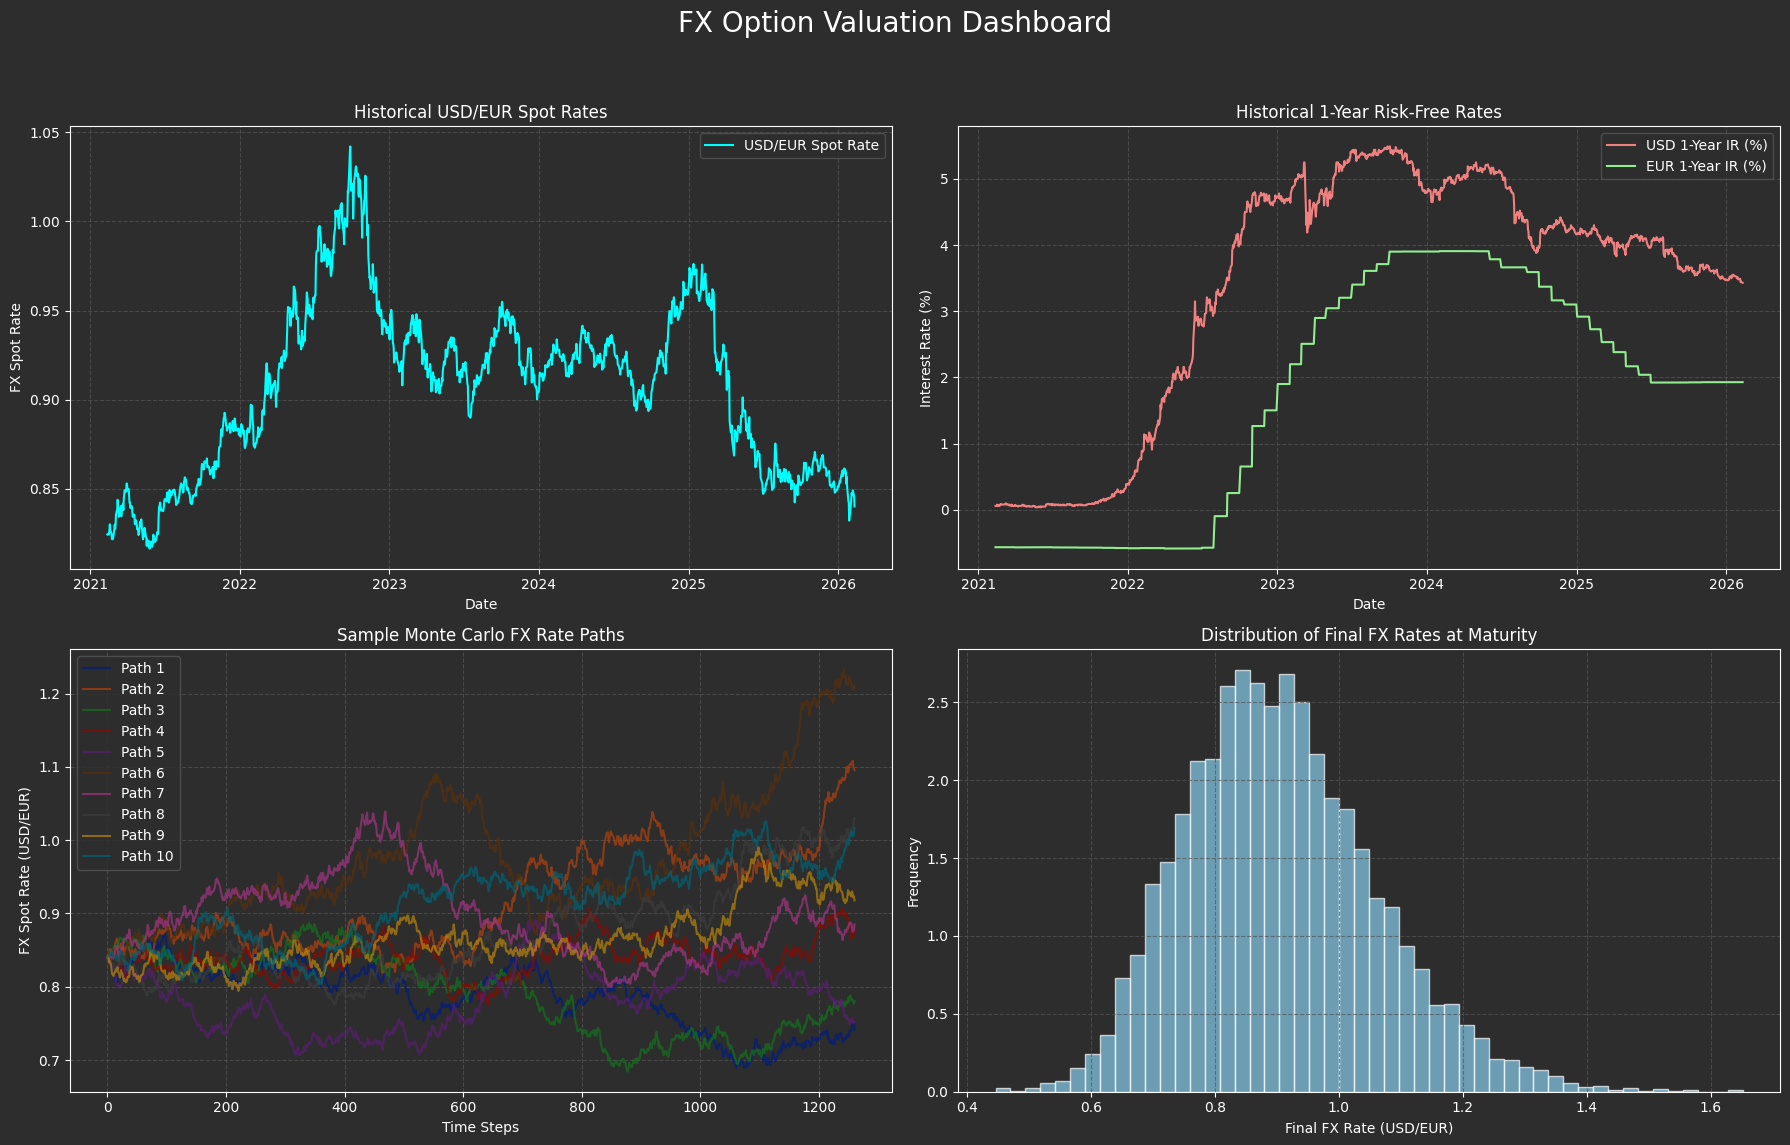

Generated a focused dashboard with selected FX option valuation plots.


In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Create a figure and a grid of subplots for a 2x2 layout
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
fig.suptitle('FX Option Valuation Dashboard', fontsize=20, color='white')

# --- Plot 1: Historical USD/EUR Spot Rates (axes[0, 0]) ---
axes[0, 0].plot(combined_data.index, combined_data['USD_EUR_Spot'], label='USD/EUR Spot Rate', color='cyan')
axes[0, 0].set_title('Historical USD/EUR Spot Rates', color='white')
axes[0, 0].set_xlabel('Date', color='white')
axes[0, 0].set_ylabel('FX Spot Rate', color='white')
axes[0, 0].legend(facecolor='#2d2d2d', edgecolor='#555555')
axes[0, 0].grid(True, color='#555555', linestyle='--', alpha=0.7)

# --- Plot 2: Historical Interest Rates (axes[0, 1]) ---
axes[0, 1].plot(combined_data.index, combined_data['USD_IR'] * 100, label='USD 1-Year IR (%)', color='lightcoral')
axes[0, 1].plot(combined_data.index, combined_data['EUR_IR'] * 100, label='EUR 1-Year IR (%)', color='lightgreen')
axes[0, 1].set_title('Historical 1-Year Risk-Free Rates', color='white')
axes[0, 1].set_xlabel('Date', color='white')
axes[0, 1].set_ylabel('Interest Rate (%)', color='white')
axes[0, 1].legend(facecolor='#2d2d2d', edgecolor='#555555')
axes[0, 1].grid(True, color='#555555', linestyle='--', alpha=0.7)

# --- Plot 3: Sample Monte Carlo FX Rate Paths (axes[1, 0]) ---
num_paths_to_plot = 10
random_indices = np.random.choice(num_simulations, num_paths_to_plot, replace=False)
time_steps = np.arange(0, num_steps + 1)
for i, idx in enumerate(random_indices):
    axes[1, 0].plot(time_steps, simulated_spot_paths[idx, :], label=f'Path {i+1}', alpha=0.7)
axes[1, 0].set_title('Sample Monte Carlo FX Rate Paths', color='white')
axes[1, 0].set_xlabel('Time Steps', color='white')
axes[1, 0].set_ylabel('FX Spot Rate (USD/EUR)', color='white')
axes[1, 0].legend(facecolor='#2d2d2d', edgecolor='#555555')
axes[1, 0].grid(True, color='#555555', linestyle='--', alpha=0.7)

# --- Plot 4: Distribution of Final FX Rates (axes[1, 1]) ---
axes[1, 1].hist(final_simulated_spot_rates, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='white')
axes[1, 1].set_title('Distribution of Final FX Rates at Maturity', color='white')
axes[1, 1].set_xlabel('Final FX Rate (USD/EUR)', color='white')
axes[1, 1].set_ylabel('Frequency', color='white')
axes[1, 1].grid(True, color='#555555', linestyle='--', alpha=0.7)

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust rect to make space for suptitle
plt.show()

print("Generated a focused dashboard with selected FX option valuation plots.")